In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from skimage import filters,morphology,measure
from scipy.stats import pearsonr
import seaborn as sns
from ncolor import label
from timeit import default_timer
import pickle as pk, glob, os
import momia2 as mo
from ncolor import label
import tifffile

In [74]:
def get_mask_combined(phase,fl,fl_threshold=110,min_particle_size=200):
    fl_bg_removed=mo.utils.correction.rolling_ball_bg_subtraction(fl)
    ph_bp=mo.utils.dual_bandpass(phase,
                                 pixel_microns=0.065,
                                 min_structure_scale=0.1,
                                 max_structure_scale=10)
    
    fl_mask = morphology.binary_dilation(filters.gaussian(fl_bg_removed,preserve_range=True)>fl_threshold,
                                         morphology.disk(5))*1
    ph_mask = ph_bp<filters.threshold_isodata(ph_bp)*1
    mask = morphology.remove_small_objects((fl_mask+ph_mask)==2,200)
    return mask,ph_bp,fl_bg_removed,ph_mask

In [105]:
for k in sorted(glob.glob('/Volumes/JZSSD_temp/20190709_NQTF/driftcorrected*.tif')):
    img = tifffile.imread(k)
    header = k.split('driftcorrected_')[-1].split('.tif')[0]
    phase_area = []
    average_intensity = []
    mask_ref,ph_bp_ref,fl_bg_ref,ph_mask = get_mask_combined(img[6,1],img[6,0])
    phase_bg = morphology.binary_closing(ph_mask*1-mask_ref*1)
    masks_for_plotting = []
    for i in range(0,5):
        fl_bg_removed=mo.utils.correction.rolling_ball_bg_subtraction(img[i,0])
        ph_bp=mo.utils.dual_bandpass(img[i,1],
                                     pixel_microns=0.065,
                                     min_structure_scale=0.1,
                                     max_structure_scale=10)
        ph_mask = morphology.binary_opening(ph_bp<filters.threshold_isodata(ph_bp)*1)
        ph_mask_labeled = measure.label(ph_mask)
        rp = measure.regionprops(ph_mask_labeled,intensity_image=phase_bg)
        canvas = np.zeros(ph_mask.shape)
        for x in rp:
            label = x.label
            _x,_y = x.coords.T
            mean_intensity = x.mean_intensity
            if mean_intensity<0.1:
                canvas[_x,_y]=1
        phase_area.append(canvas.sum())
        average_intensity.append(img[i,0][canvas==1].mean())
        if i in [0,4]:
            masks_for_plotting.append(canvas.astype(int))

    for i in range(5,90):
        mask,ph,fl_bg,ph_mask = get_mask_combined(img[i,1],img[i,0])
        phase_area.append(mask.sum())
        average_intensity.append(img[i,0][mask==1].mean())
        if i in [5,20,40,60,80]:
            masks_for_plotting.append(mask.astype(int))
    np.save('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/{}_stats.npy'.format(header),
        np.array([phase_area,average_intensity]))
    np.save('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/{}_demo_masks.npy'.format(header),
        np.array(masks_for_plotting))

In [3]:
from matplotlib import pyplot as plt, cm
from matplotlib.gridspec import GridSpec as gs
import pandas as pd, numpy as np, seaborn as sns, os, glob

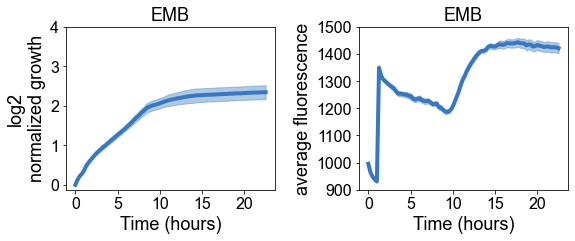

In [4]:
group_stat = []
for i in range(1,6):
    k = '/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/{}_stats.npy'.format(str(i).zfill(2))
    if os.path.isfile(k):
        group_stat.append(np.load(k))
group_stat = np.array(group_stat)
color = np.array([57,120,191])/255
areas = group_stat[:,0,:]
area0 = group_stat[:,0,:][:,0]
log_area = np.log2(areas/area0[:,np.newaxis])
filtered_log_area = log_area[np.array([0,2,3]),:]

fl = group_stat[:,1,:]
filtered_fl = fl[np.array([0,2,3]),:]

mean_log_area = np.mean(filtered_log_area,axis=0)
std_log_area = np.std(filtered_log_area,axis=0)

mean_fl = np.mean(filtered_fl,axis=0)
std_fl = np.std(filtered_fl,axis=0)

fig,axes=plt.subplots(figsize=(9,3),ncols=2,gridspec_kw={'wspace':0.4})
axes[0].plot(np.linspace(0,90*0.25,90),mean_log_area,color=color,lw=4)
axes[0].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_log_area-std_log_area,
                y2=mean_log_area+std_log_area,alpha=0.4,color=color)
axes[0].set_xticks([0,5,10,15,20])
axes[0].set_yticks([0,1,2,3,4])
axes[0].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[0].set_yticklabels([0,1,2,3,4],fontsize=16,fontname='Arial')
axes[0].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[0].set_ylabel('log2\nnormalized growth',fontsize=18,fontname='Arial')
axes[0].set_title('EMB',fontsize=18,fontname='Arial')

axes[1].plot(np.linspace(0,90*0.25,90),mean_fl,color=color,lw=4)
axes[1].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_fl-std_fl,
                y2=mean_fl+std_fl,alpha=0.4,color=color)
axes[1].set_xticks([0,5,10,15,20])
axes[1].set_yticks([900,1000,1100,1200,1300,1400,1500])
axes[1].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[1].set_yticklabels([900,1000,1100,1200,1300,1400,1500],fontsize=16,fontname='Arial')
axes[1].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[1].set_ylabel('average fluorescence',fontsize=18,fontname='Arial')
axes[1].set_title('EMB',fontsize=18,fontname='Arial')
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/EMB_basics.png',dpi=160,bbox_inches='tight')

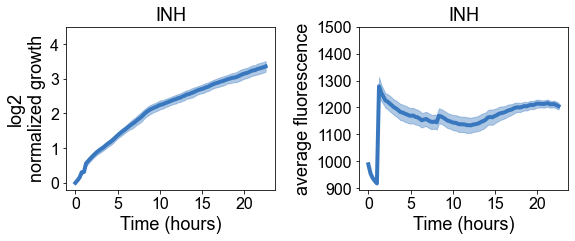

In [120]:
group_stat = []
for i in range(6,11):
    k = '/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/{}_stats.npy'.format(str(i).zfill(2))
    if os.path.isfile(k):
        group_stat.append(np.load(k))
group_stat = np.array(group_stat)
color = np.array([57,120,191])/255
areas = group_stat[:,0,:]
area0 = group_stat[:,0,:][:,0]
log_area = np.log2(areas/area0[:,np.newaxis])
filtered_log_area = log_area[np.array([1,2,3]),:]

fl = group_stat[:,1,:]
filtered_fl = fl[np.array([1,2,3]),:]

mean_log_area = np.mean(filtered_log_area,axis=0)
std_log_area = np.std(filtered_log_area,axis=0)

mean_fl = np.mean(filtered_fl,axis=0)
std_fl = np.std(filtered_fl,axis=0)

fig,axes=plt.subplots(figsize=(9,3),ncols=2,gridspec_kw={'wspace':0.4})
axes[0].plot(np.linspace(0,90*0.25,90),mean_log_area,color=color,lw=4)
axes[0].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_log_area-std_log_area,
                y2=mean_log_area+std_log_area,alpha=0.4,color=color)
axes[0].set_xticks([0,5,10,15,20])
axes[0].set_yticks([0,1,2,3,4])

axes[0].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[0].set_yticklabels([0,1,2,3,4],fontsize=16,fontname='Arial')
axes[0].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[0].set_ylabel('log2\nnormalized growth',fontsize=18,fontname='Arial')
axes[0].set_title('INH',fontsize=18,fontname='Arial')

axes[1].plot(np.linspace(0,90*0.25,90),mean_fl,color=color,lw=4)
axes[1].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_fl-std_fl,
                y2=mean_fl+std_fl,alpha=0.4,color=color)
axes[1].set_xticks([0,5,10,15,20])
axes[1].set_yticks([900,1000,1100,1200,1300,1400,1500])
axes[1].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[1].set_yticklabels([900,1000,1100,1200,1300,1400,1500],fontsize=16,fontname='Arial')
axes[1].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[1].set_ylabel('average fluorescence',fontsize=18,fontname='Arial')
axes[1].set_title('INH',fontsize=18,fontname='Arial')
axes[0].set_ylim(-0.2,4.5)
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/INH_basics.png',dpi=160,bbox_inches='tight')

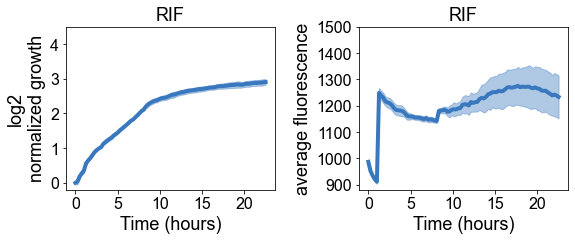

In [117]:
group_stat = []
for i in range(11,16):
    k = '/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/{}_stats.npy'.format(str(i).zfill(2))
    if os.path.isfile(k):
        group_stat.append(np.load(k))
group_stat = np.array(group_stat)
color = np.array([57,120,191])/255
areas = group_stat[:,0,:]
area0 = group_stat[:,0,:][:,0]
log_area = np.log2(areas/area0[:,np.newaxis])
filtered_log_area = log_area[np.array([1,2,3]),:]

fl = group_stat[:,1,:]
filtered_fl = fl[np.array([1,2,3]),:]

mean_log_area = np.mean(filtered_log_area,axis=0)
std_log_area = np.std(filtered_log_area,axis=0)

mean_fl = np.mean(filtered_fl,axis=0)
std_fl = np.std(filtered_fl,axis=0)

fig,axes=plt.subplots(figsize=(9,3),ncols=2,gridspec_kw={'wspace':0.4})
axes[0].plot(np.linspace(0,90*0.25,90),mean_log_area,color=color,lw=4)
axes[0].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_log_area-std_log_area,
                y2=mean_log_area+std_log_area,alpha=0.4,color=color)
axes[0].set_xticks([0,5,10,15,20])
axes[0].set_yticks([0,1,2,3,4])

axes[0].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[0].set_yticklabels([0,1,2,3,4],fontsize=16,fontname='Arial')
axes[0].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[0].set_ylabel('log2\nnormalized growth',fontsize=18,fontname='Arial')
axes[0].set_title('RIF',fontsize=18,fontname='Arial')

axes[1].plot(np.linspace(0,90*0.25,90),mean_fl,color=color,lw=4)
axes[1].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_fl-std_fl,
                y2=mean_fl+std_fl,alpha=0.4,color=color)
axes[1].set_xticks([0,5,10,15,20])
axes[1].set_yticks([900,1000,1100,1200,1300,1400,1500])
axes[1].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[1].set_yticklabels([900,1000,1100,1200,1300,1400,1500],fontsize=16,fontname='Arial')
axes[1].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[1].set_ylabel('average fluorescence',fontsize=18,fontname='Arial')
axes[1].set_title('RIF',fontsize=18,fontname='Arial')
axes[0].set_ylim(-0.2,4.5)
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/RIF_basics.png',dpi=160,bbox_inches='tight')

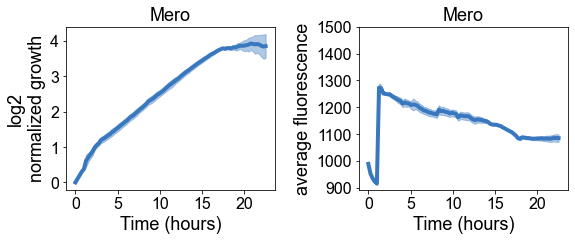

In [113]:
group_stat = []
for i in range(16,21):
    k = '/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/{}_stats.npy'.format(str(i).zfill(2))
    if os.path.isfile(k):
        group_stat.append(np.load(k))
group_stat = np.array(group_stat)
color = np.array([57,120,191])/255
areas = group_stat[:,0,:]
area0 = group_stat[:,0,:][:,0]
log_area = np.log2(areas/area0[:,np.newaxis])
filtered_log_area = log_area[np.array([1,2,3]),:]

fl = group_stat[:,1,:]
filtered_fl = fl[np.array([1,2,3]),:]

mean_log_area = np.mean(filtered_log_area,axis=0)
std_log_area = np.std(filtered_log_area,axis=0)

mean_fl = np.mean(filtered_fl,axis=0)
std_fl = np.std(filtered_fl,axis=0)

fig,axes=plt.subplots(figsize=(9,3),ncols=2,gridspec_kw={'wspace':0.4})
axes[0].plot(np.linspace(0,90*0.25,90),mean_log_area,color=color,lw=4)
axes[0].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_log_area-std_log_area,
                y2=mean_log_area+std_log_area,alpha=0.4,color=color)
axes[0].set_xticks([0,5,10,15,20])
axes[0].set_yticks([0,1,2,3,4])

axes[0].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[0].set_yticklabels([0,1,2,3,4],fontsize=16,fontname='Arial')
axes[0].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[0].set_ylabel('log2\nnormalized growth',fontsize=18,fontname='Arial')
axes[0].set_title('Mero',fontsize=18,fontname='Arial')

axes[1].plot(np.linspace(0,90*0.25,90),mean_fl,color=color,lw=4)
axes[1].fill_between(x=np.linspace(0,90*0.25,90),
                y1=mean_fl-std_fl,
                y2=mean_fl+std_fl,alpha=0.4,color=color)
axes[1].set_xticks([0,5,10,15,20])
axes[1].set_yticks([900,1000,1100,1200,1300,1400,1500])
axes[1].set_xticklabels([0,5,10,15,20],fontsize=16,fontname='Arial')
axes[1].set_yticklabels([900,1000,1100,1200,1300,1400,1500],fontsize=16,fontname='Arial')
axes[1].set_xlabel('Time (hours)',fontsize=18,fontname='Arial')
axes[1].set_ylabel('average fluorescence',fontsize=18,fontname='Arial')
axes[1].set_title('Mero',fontsize=18,fontname='Arial')
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/Mero_basics.png',dpi=160,bbox_inches='tight')

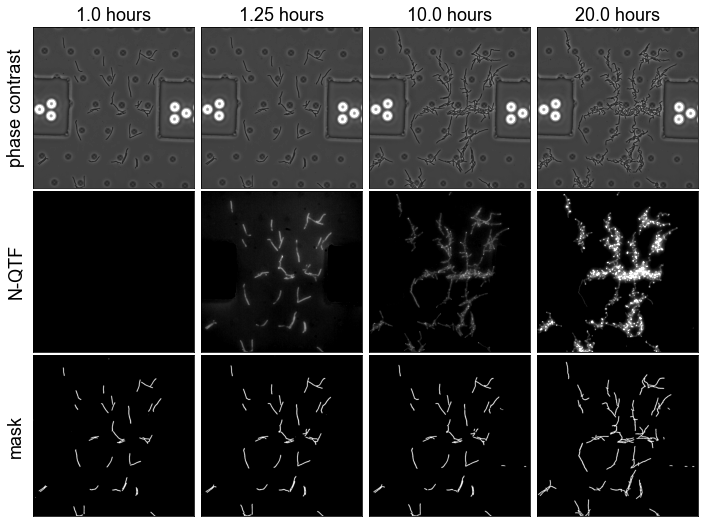

In [141]:
### now make figures to demonstrate how we analyzed the data
time_points = [4,5,40,80]
selected_frames = [1,2,4,6]
fig=plt.figure(figsize=(12,9))
grids = gs(3,4,hspace=0.02,wspace=0.02)
#img = tifffile.imread('/Volumes/JZSSD_temp/20190709_NQTF/driftcorrected_01.tif')
#masks = np.load('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/01_demo_masks.npy')

for i,f in enumerate(selected_frames):
    ax1 = fig.add_subplot(grids[0,i])
    ax2 = fig.add_subplot(grids[1,i])
    ax3 = fig.add_subplot(grids[2,i])
    ax1.imshow(img[time_points[i],1],cmap='gist_gray',vmin=1000,vmax=10000)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(img[time_points[i],0],cmap='gist_gray',vmin=1020,vmax=1800)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.imshow(masks[i],cmap='gist_gray',vmin=0,vmax=1)
    ax3.set_xticks([])
    ax3.set_yticks([])
    if i==0:
        ax1.set_ylabel('phase contrast',fontsize=18,fontname='Arial')
        ax2.set_ylabel('N-QTF',fontsize=18,fontname='Arial')
        ax3.set_ylabel('mask',fontsize=18,fontname='Arial')
    ax1.set_title('{} hours'.format(round(time_points[i]*0.25,2)),fontsize=18,fontname='Arial')
plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/1_intensity_plots_basic/intensity_demo.png',dpi=160,bbox_inches='tight')